In [1]:
import warnings
from pandas.errors import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [2]:
import pandas as pd

DataPath = './Dataset/VietNamWeather.csv'
Dataframe = pd.read_csv(DataPath).reset_index(drop=True)

Dataframe.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181960 entries, 0 to 181959
Data columns (total 10 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   province  181960 non-null  object 
 1   max       181960 non-null  int64  
 2   min       181960 non-null  int64  
 3   wind      181960 non-null  int64  
 4   wind_d    181960 non-null  object 
 5   rain      181960 non-null  float64
 6   humidi    181960 non-null  int64  
 7   cloud     181960 non-null  int64  
 8   pressure  181960 non-null  int64  
 9   date      181960 non-null  object 
dtypes: float64(1), int64(6), object(3)
memory usage: 13.9+ MB


In [3]:
Dataframe['temp'] = (Dataframe['max'] + Dataframe['min']) / 2
NewDf = Dataframe[['temp', 'wind', 'humidi', 'cloud', 'pressure']]

RainThreshold = 0.5
NewDf['israin'] = (Dataframe['rain'] > RainThreshold).astype(int)

NewDf['wind'] *= 0.277777778 # km/h to m/s

NewDf.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181960 entries, 0 to 181959
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   temp      181960 non-null  float64
 1   wind      181960 non-null  float64
 2   humidi    181960 non-null  int64  
 3   cloud     181960 non-null  int64  
 4   pressure  181960 non-null  int64  
 5   israin    181960 non-null  int64  
dtypes: float64(2), int64(4)
memory usage: 8.3 MB


In [4]:
NewDf.head(10)

,temp,wind,humidi,cloud,pressure,israin
0,24.5,4.722222,90,71,1010,1
1,28.0,5.555556,64,24,1010,0
2,26.5,3.888889,75,45,1008,0
3,27.0,8.333333,79,52,1012,0
4,28.0,5.555556,70,24,1010,0
5,25.5,3.888889,75,55,1012,0
6,26.0,2.777778,75,42,1012,0
7,28.0,6.111111,63,9,1015,0
8,27.0,5.555556,76,35,1011,0
9,26.0,4.444444,70,33,1010,0


In [5]:
import numpy as np

Data = NewDf.drop(columns='israin').values
Target = NewDf['israin'].values

np.save('./Data.npy', Data)
np.save('./Target.npy', Target)

In [6]:
from sklearn.preprocessing import LabelEncoder, StandardScaler, Normalizer
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('Standard scaling', StandardScaler()),
     ('Normalize', Normalizer())]).fit(X=Data, y=Target)

Data = pipeline.transform(X=Data)
Target = LabelEncoder().fit_transform(Target)

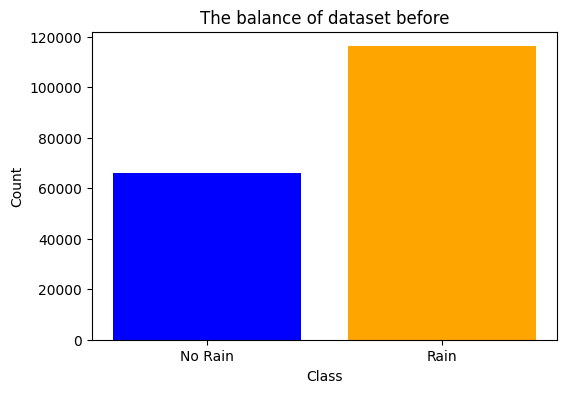

In [7]:
import matplotlib.pyplot as plt
import numpy as np

unique_values, counts = np.unique(Target, return_counts=True)

plt.figure(figsize=(6, 4))
plt.bar(unique_values, counts, color=['blue', 'orange'])
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('The balance of dataset before')
plt.xticks(unique_values, ['No Rain', 'Rain'])
plt.show()

In [8]:
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [9]:
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader


class CustomDataset(Dataset):
    def __init__(self, data, label):
      super().__init__()
      self.train = data
      self.label = label

    def __len__(self):
      return self.train.shape[0]

    def __getitem__(self, index: int):
        return self.train[index], self.label[index]

X_train, X_test, Y_train, Y_test = train_test_split(Data, Target, test_size=0.2)

# Convert data to PyTorch tensors and move to GPU
TrainData = torch.tensor(X_train, dtype=torch.float32, device=device)
TrainLabel = torch.tensor(Y_train, dtype=torch.long, device=device)

ValidData = torch.tensor(X_test, dtype=torch.float32, device=device)
ValidLabel = torch.tensor(Y_test, dtype=torch.long, device=device)

# Create dataloader
TrainDataset = CustomDataset(TrainData, TrainLabel)
ValidDataset = CustomDataset(ValidData, ValidLabel)

TrainDataloader = DataLoader(TrainDataset, batch_size=64, shuffle=True, num_workers=4)
ValidDataloader = DataLoader(ValidDataset, batch_size=64, shuffle=True, num_workers=4)

In [10]:
import torch

class EarlyStopping:
    def __init__(self, patience=10, delta=0):
        self.report = None
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_loss = None
        self.best_acc = None
        self.early_stop = False

    def __call__(self, model, val_loss, val_acc, report):


        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_acc = val_acc
            self.report = report
            ExportPATH = f'./ModelCheckpoint/SoftOrdering1DCNN.pth'
            torch.save(model.state_dict(), ExportPATH)

        elif val_loss > self.best_loss + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            print(f'Best loss: {self.best_loss}')
            print(f'Best accuracy: {self.best_acc}')

            if self.counter >= self.patience:
                self.early_stop = True

        else:
            self.best_loss = val_loss
            self.best_acc = val_acc
            self.report = report
            self.counter = 0
            ExportPATH = f'./ModelCheckpoint/SoftOrdering1DCNN.pth'
            torch.save(model.state_dict(), ExportPATH)

In [11]:
from torch.cuda.amp import autocast, GradScaler
from tqdm import tqdm
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

def TrainModel(model, loss_fn, optimizer, train_loader, scheduler=None, schd_batch_update=False):
        model.train()
        running_loss = None

        pbar = tqdm(enumerate(train_loader), total=len(train_loader))
        for step, (data, label) in pbar:
            scaler = GradScaler()
            with autocast():
                output = model(data)
                loss = loss_fn(output, label)
                scaler.scale(loss).backward()

                if running_loss is None:
                    running_loss = loss.item()
                else:
                    running_loss = running_loss * .99 + loss.item() * .01

                if ((step + 1) %  2 == 0) or ((step + 1) == len(train_loader)):
                    scaler.step(optimizer)
                    scaler.update()
                    optimizer.zero_grad()

                    if scheduler is not None and schd_batch_update:
                        scheduler.step()

                if ((step + 1) % 2 == 0) or ((step + 1) == len(train_loader)):
                    description = f'Loss: {running_loss:.4f}'

                    pbar.set_description(description)

        if scheduler is not None and not schd_batch_update:
           scheduler.step()

def EvalModel(model, loss_fn, val_loader, early_stopping=None, scheduler=None, schd_loss_update=False):
        model.eval()

        loss_sum = 0
        sample_num = 0
        preds_all = []
        targets_all = []

        pbar = tqdm(enumerate(val_loader), total=len(val_loader))
        for step, (data, label) in pbar:
            predict = model(data)
            preds_all += [torch.argmax(predict, 1).detach().cpu().numpy()]
            targets_all += [label.detach().cpu().numpy()]

            loss = loss_fn(predict, label)

            loss_sum += loss.item() * label.shape[0]
            sample_num += label.shape[0]

            if ((step + 1) % 2 == 0) or ((step + 1) == len(val_loader)):
                description = f'Loss: {loss_sum/sample_num:.4f}'
                pbar.set_description(description)

        preds_all = np.concatenate(preds_all)
        targets_all = np.concatenate(targets_all)

        report = classification_report(targets_all, preds_all, digits=4)
        print("Classification report")
        print(report)
        print("F1 micro averaging:",(f1_score(targets_all, preds_all, average='micro')))

        ValidLoss = loss_sum/sample_num
        ValidAcc = (preds_all==targets_all).mean()

        print('Validation loss', ValidLoss)
        print('Validation accuracy', ValidAcc)
        if early_stopping != None:
          early_stopping(model, ValidLoss, ValidAcc, report)

        if scheduler is not None:
            if schd_loss_update:
                scheduler.step(loss_sum/sample_num)
            else:
                scheduler.step()

In [12]:
from SoftOrdering1DCNN import SoftOrdering1DCNN
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch import nn
torch.backends.cudnn.benchmark = True

input_dim = TrainData.shape[1]
numclass = len(np.unique(TrainLabel.cpu()))
print(f'Feature: {input_dim}')
print(f'Classes: {numclass}')

print('Start building Model...')
model = SoftOrdering1DCNN(input_dim, numclass)
model.to(device)
print('Build Model successfully!')

from adabelief_pytorch import AdaBelief
optimizer = AdaBelief(model.parameters(),
                      lr=1e-3, eps=1e-16, betas=(0.9,0.999), weight_decay=1e-4,
                      weight_decouple=False, rectify=False, fixed_decay=False, amsgrad=False)
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=1, eta_min=1e-4, last_epoch=-1)
early_stopping = EarlyStopping(patience=10)

loss_tr = nn.CrossEntropyLoss().to(device)
loss_vl = nn.CrossEntropyLoss().to(device)

epoch = 0
while True:
    epoch += 1
    print('=================================================')
    print(f'\n[ TRAINING EPOCH {epoch} ]')
    TrainModel(model, loss_tr, optimizer, TrainDataloader, scheduler=scheduler, schd_batch_update=True)
    with torch.no_grad():
      print('\n[ EVALUATING VALIDATION ACCURACY ]')
      EvalModel(model, loss_vl, ValidDataloader, early_stopping)
      print('\n-------------------------------------------------\n')
      if early_stopping.early_stop:
            break

Feature: 5
Classes: 2
Start building Model...
Build Model successfully!
Please check your arguments if you have upgraded adabelief-pytorch from version 0.0.5.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  ---------
adabelief-pytorch=0.0.5  1e-08  False              False
>=0.1.0 (Current 0.2.0)  1e-16  True               True
SGD better than Adam (e.g. CNN for Image Classification)    Adam better than SGD (e.g. Transformer, GAN)
----------------------------------------------------------  ----------------------------------------------
Recommended eps = 1e-8                                      Recommended eps = 1e-16
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer
You can disable the log message by setting "print_change_log = False", though it is recommended to keep as a reminder.



/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")



[ TRAINING EPOCH 1 ]


  0%|          | 0/2275 [00:00<?, ?it/s]/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Loss: 0.5059: 100%|██████████| 2275/2275 [00:42<00:00, 53.61it/s]



[ EVALUATING VALIDATION ACCURACY ]


Loss: 0.4801: 100%|██████████| 569/569 [00:04<00:00, 121.07it/s]


Classification report
              precision    recall  f1-score   support

           0     0.8293    0.6580    0.7338     13302
           1     0.8239    0.9220    0.8702     23090

    accuracy                         0.8255     36392
   macro avg     0.8266    0.7900    0.8020     36392
weighted avg     0.8259    0.8255    0.8203     36392

F1 micro averaging: 0.8254836227742361
Validation loss 0.4800712869282108
Validation accuracy 0.8254836227742361

-------------------------------------------------


[ TRAINING EPOCH 2 ]


  0%|          | 0/2275 [00:00<?, ?it/s]/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Loss: 0.5028: 100%|██████████| 2275/2275 [00:40<00:00, 55.57it/s]


[ EVALUATING VALIDATION ACCURACY ]



Loss: 0.4782: 100%|██████████| 569/569 [00:04<00:00, 128.83it/s]


Classification report
              precision    recall  f1-score   support

           0     0.8342    0.6610    0.7376     13302
           1     0.8256    0.9243    0.8722     23090

    accuracy                         0.8281     36392
   macro avg     0.8299    0.7927    0.8049     36392
weighted avg     0.8287    0.8281    0.8230     36392

F1 micro averaging: 0.8280666080457243
Validation loss 0.47824738305541126
Validation accuracy 0.8280666080457243

-------------------------------------------------


[ TRAINING EPOCH 3 ]


  0%|          | 0/2275 [00:00<?, ?it/s]/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Loss: 0.5028: 100%|██████████| 2275/2275 [00:39<00:00, 56.97it/s]


[ EVALUATING VALIDATION ACCURACY ]



Loss: 0.4754: 100%|██████████| 569/569 [00:04<00:00, 127.64it/s]


Classification report
              precision    recall  f1-score   support

           0     0.8176    0.6897    0.7482     13302
           1     0.8360    0.9113    0.8720     23090

    accuracy                         0.8303     36392
   macro avg     0.8268    0.8005    0.8101     36392
weighted avg     0.8293    0.8303    0.8268     36392

F1 micro averaging: 0.8303198505165971
Validation loss 0.4753919992899732
Validation accuracy 0.8303198505165971

-------------------------------------------------


[ TRAINING EPOCH 4 ]


  0%|          | 0/2275 [00:00<?, ?it/s]/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Loss: 0.4971: 100%|██████████| 2275/2275 [00:40<00:00, 55.70it/s]


[ EVALUATING VALIDATION ACCURACY ]



Loss: 0.4751: 100%|██████████| 569/569 [00:04<00:00, 123.31it/s]


Classification report
              precision    recall  f1-score   support

           0     0.8263    0.6804    0.7463     13302
           1     0.8329    0.9176    0.8732     23090

    accuracy                         0.8309     36392
   macro avg     0.8296    0.7990    0.8097     36392
weighted avg     0.8305    0.8309    0.8268     36392

F1 micro averaging: 0.8308969004176742
Validation loss 0.47512263106786173
Validation accuracy 0.8308969004176742

-------------------------------------------------


[ TRAINING EPOCH 5 ]


  0%|          | 0/2275 [00:00<?, ?it/s]/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Loss: 0.4988: 100%|██████████| 2275/2275 [00:40<00:00, 56.45it/s]


[ EVALUATING VALIDATION ACCURACY ]



Loss: 0.4764: 100%|██████████| 569/569 [00:04<00:00, 127.60it/s]


Classification report
              precision    recall  f1-score   support

           0     0.8368    0.6609    0.7385     13302
           1     0.8257    0.9257    0.8729     23090

    accuracy                         0.8289     36392
   macro avg     0.8312    0.7933    0.8057     36392
weighted avg     0.8298    0.8289    0.8238     36392

F1 micro averaging: 0.8289184436139811
Validation loss 0.47636470672297565
Validation accuracy 0.8289184436139811
EarlyStopping counter: 1 out of 10
Best loss: 0.47512263106786173
Best accuracy: 0.8308969004176742

-------------------------------------------------


[ TRAINING EPOCH 6 ]


  0%|          | 0/2275 [00:00<?, ?it/s]/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Loss: 0.4967: 100%|██████████| 2275/2275 [00:39<00:00, 57.01it/s]


[ EVALUATING VALIDATION ACCURACY ]



Loss: 0.4740: 100%|██████████| 569/569 [00:04<00:00, 126.22it/s]


Classification report
              precision    recall  f1-score   support

           0     0.8163    0.6970    0.7519     13302
           1     0.8390    0.9097    0.8729     23090

    accuracy                         0.8319     36392
   macro avg     0.8277    0.8033    0.8124     36392
weighted avg     0.8307    0.8319    0.8287     36392

F1 micro averaging: 0.8319136073862388
Validation loss 0.47397989959710507
Validation accuracy 0.8319136073862388

-------------------------------------------------


[ TRAINING EPOCH 7 ]


  0%|          | 0/2275 [00:00<?, ?it/s]/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Loss: 0.5012: 100%|██████████| 2275/2275 [00:40<00:00, 55.49it/s]


[ EVALUATING VALIDATION ACCURACY ]



Loss: 0.4738: 100%|██████████| 569/569 [00:04<00:00, 125.37it/s]


Classification report
              precision    recall  f1-score   support

           0     0.8055    0.7085    0.7539     13302
           1     0.8430    0.9015    0.8712     23090

    accuracy                         0.8309     36392
   macro avg     0.8242    0.8050    0.8126     36392
weighted avg     0.8293    0.8309    0.8283     36392

F1 micro averaging: 0.8309243789843921
Validation loss 0.4737578575743191
Validation accuracy 0.8309243789843922

-------------------------------------------------


[ TRAINING EPOCH 8 ]


  0%|          | 0/2275 [00:00<?, ?it/s]/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Loss: 0.5005: 100%|██████████| 2275/2275 [00:40<00:00, 56.08it/s]


[ EVALUATING VALIDATION ACCURACY ]



Loss: 0.4739: 100%|██████████| 569/569 [00:04<00:00, 124.40it/s]


Classification report
              precision    recall  f1-score   support

           0     0.8221    0.6864    0.7482     13302
           1     0.8350    0.9144    0.8729     23090

    accuracy                         0.8311     36392
   macro avg     0.8286    0.8004    0.8105     36392
weighted avg     0.8303    0.8311    0.8273     36392

F1 micro averaging: 0.8310892503846999
Validation loss 0.4738818351764893
Validation accuracy 0.8310892503846999
EarlyStopping counter: 1 out of 10
Best loss: 0.4737578575743191
Best accuracy: 0.8309243789843922

-------------------------------------------------


[ TRAINING EPOCH 9 ]


  0%|          | 0/2275 [00:00<?, ?it/s]/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Loss: 0.5002: 100%|██████████| 2275/2275 [00:40<00:00, 56.66it/s]


[ EVALUATING VALIDATION ACCURACY ]



Loss: 0.4739: 100%|██████████| 569/569 [00:04<00:00, 127.22it/s]


Classification report
              precision    recall  f1-score   support

           0     0.7968    0.7206    0.7568     13302
           1     0.8474    0.8942    0.8702     23090

    accuracy                         0.8307     36392
   macro avg     0.8221    0.8074    0.8135     36392
weighted avg     0.8289    0.8307    0.8287     36392

F1 micro averaging: 0.8307045504506485
Validation loss 0.4739433094272773
Validation accuracy 0.8307045504506485
EarlyStopping counter: 2 out of 10
Best loss: 0.4737578575743191
Best accuracy: 0.8309243789843922

-------------------------------------------------


[ TRAINING EPOCH 10 ]


  0%|          | 0/2275 [00:00<?, ?it/s]/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Loss: 0.4962: 100%|██████████| 2275/2275 [00:40<00:00, 56.12it/s]


[ EVALUATING VALIDATION ACCURACY ]



Loss: 0.4745: 100%|██████████| 569/569 [00:04<00:00, 124.47it/s]


Classification report
              precision    recall  f1-score   support

           0     0.7844    0.7368    0.7599     13302
           1     0.8535    0.8833    0.8682     23090

    accuracy                         0.8298     36392
   macro avg     0.8189    0.8101    0.8140     36392
weighted avg     0.8282    0.8298    0.8286     36392

F1 micro averaging: 0.8297702791822379
Validation loss 0.4745202375967756
Validation accuracy 0.8297702791822379
EarlyStopping counter: 3 out of 10
Best loss: 0.4737578575743191
Best accuracy: 0.8309243789843922

-------------------------------------------------


[ TRAINING EPOCH 11 ]


  0%|          | 0/2275 [00:00<?, ?it/s]/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Loss: 0.4986: 100%|██████████| 2275/2275 [00:40<00:00, 56.61it/s]


[ EVALUATING VALIDATION ACCURACY ]



Loss: 0.4748: 100%|██████████| 569/569 [00:04<00:00, 126.67it/s]


Classification report
              precision    recall  f1-score   support

           0     0.7896    0.7297    0.7585     13302
           1     0.8508    0.8880    0.8690     23090

    accuracy                         0.8301     36392
   macro avg     0.8202    0.8089    0.8137     36392
weighted avg     0.8284    0.8301    0.8286     36392

F1 micro averaging: 0.8301275005495712
Validation loss 0.47478805645189853
Validation accuracy 0.8301275005495713
EarlyStopping counter: 4 out of 10
Best loss: 0.4737578575743191
Best accuracy: 0.8309243789843922

-------------------------------------------------


[ TRAINING EPOCH 12 ]


  0%|          | 0/2275 [00:00<?, ?it/s]/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Loss: 0.4934: 100%|██████████| 2275/2275 [00:40<00:00, 55.50it/s]


[ EVALUATING VALIDATION ACCURACY ]



Loss: 0.4748: 100%|██████████| 569/569 [00:04<00:00, 126.60it/s]


Classification report
              precision    recall  f1-score   support

           0     0.7822    0.7356    0.7582     13302
           1     0.8527    0.8820    0.8671     23090

    accuracy                         0.8285     36392
   macro avg     0.8175    0.8088    0.8126     36392
weighted avg     0.8269    0.8285    0.8273     36392

F1 micro averaging: 0.8284787865464938
Validation loss 0.4747523353974566
Validation accuracy 0.8284787865464938
EarlyStopping counter: 5 out of 10
Best loss: 0.4737578575743191
Best accuracy: 0.8309243789843922

-------------------------------------------------


[ TRAINING EPOCH 13 ]


  0%|          | 0/2275 [00:00<?, ?it/s]/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Loss: 0.5004: 100%|██████████| 2275/2275 [00:40<00:00, 56.49it/s]


[ EVALUATING VALIDATION ACCURACY ]



Loss: 0.4733: 100%|██████████| 569/569 [00:04<00:00, 118.65it/s]


Classification report
              precision    recall  f1-score   support

           0     0.8078    0.7073    0.7542     13302
           1     0.8426    0.9030    0.8718     23090

    accuracy                         0.8315     36392
   macro avg     0.8252    0.8051    0.8130     36392
weighted avg     0.8299    0.8315    0.8288     36392

F1 micro averaging: 0.8314739503187515
Validation loss 0.4733494750272575
Validation accuracy 0.8314739503187514

-------------------------------------------------


[ TRAINING EPOCH 14 ]


  0%|          | 0/2275 [00:00<?, ?it/s]/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Loss: 0.4957: 100%|██████████| 2275/2275 [00:40<00:00, 55.87it/s]


[ EVALUATING VALIDATION ACCURACY ]



Loss: 0.4745: 100%|██████████| 569/569 [00:04<00:00, 123.13it/s]


Classification report
              precision    recall  f1-score   support

           0     0.8032    0.7113    0.7545     13302
           1     0.8440    0.8996    0.8709     23090

    accuracy                         0.8308     36392
   macro avg     0.8236    0.8055    0.8127     36392
weighted avg     0.8291    0.8308    0.8284     36392

F1 micro averaging: 0.8307869861508024
Validation loss 0.47446352020675836
Validation accuracy 0.8307869861508024
EarlyStopping counter: 1 out of 10
Best loss: 0.4733494750272575
Best accuracy: 0.8314739503187514

-------------------------------------------------


[ TRAINING EPOCH 15 ]


  0%|          | 0/2275 [00:00<?, ?it/s]/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Loss: 0.4994: 100%|██████████| 2275/2275 [00:41<00:00, 54.82it/s]


[ EVALUATING VALIDATION ACCURACY ]



Loss: 0.4746: 100%|██████████| 569/569 [00:04<00:00, 127.00it/s]


Classification report
              precision    recall  f1-score   support

           0     0.8220    0.6806    0.7447     13302
           1     0.8326    0.9151    0.8719     23090

    accuracy                         0.8294     36392
   macro avg     0.8273    0.7979    0.8083     36392
weighted avg     0.8287    0.8294    0.8254     36392

F1 micro averaging: 0.8294130578149043
Validation loss 0.47459179402105256
Validation accuracy 0.8294130578149044
EarlyStopping counter: 2 out of 10
Best loss: 0.4733494750272575
Best accuracy: 0.8314739503187514

-------------------------------------------------


[ TRAINING EPOCH 16 ]


  0%|          | 0/2275 [00:00<?, ?it/s]/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Loss: 0.5019: 100%|██████████| 2275/2275 [00:45<00:00, 50.44it/s]


[ EVALUATING VALIDATION ACCURACY ]



Loss: 0.4727: 100%|██████████| 569/569 [00:05<00:00, 106.81it/s]


Classification report
              precision    recall  f1-score   support

           0     0.7980    0.7186    0.7562     13302
           1     0.8467    0.8952    0.8703     23090

    accuracy                         0.8306     36392
   macro avg     0.8223    0.8069    0.8132     36392
weighted avg     0.8289    0.8306    0.8286     36392

F1 micro averaging: 0.8306495933172126
Validation loss 0.47266481949434513
Validation accuracy 0.8306495933172126

-------------------------------------------------


[ TRAINING EPOCH 17 ]


  0%|          | 0/2275 [00:00<?, ?it/s]/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Loss: 0.5021: 100%|██████████| 2275/2275 [00:50<00:00, 45.04it/s]


[ EVALUATING VALIDATION ACCURACY ]



Loss: 0.4730: 100%|██████████| 569/569 [00:06<00:00, 90.44it/s]


Classification report
              precision    recall  f1-score   support

           0     0.7923    0.7267    0.7581     13302
           1     0.8497    0.8903    0.8695     23090

    accuracy                         0.8305     36392
   macro avg     0.8210    0.8085    0.8138     36392
weighted avg     0.8287    0.8305    0.8288     36392

F1 micro averaging: 0.8304847219169048
Validation loss 0.47302703101128163
Validation accuracy 0.8304847219169048
EarlyStopping counter: 1 out of 10
Best loss: 0.47266481949434513
Best accuracy: 0.8306495933172126

-------------------------------------------------


[ TRAINING EPOCH 18 ]


  0%|          | 0/2275 [00:00<?, ?it/s]/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Loss: 0.5014: 100%|██████████| 2275/2275 [00:52<00:00, 43.39it/s]


[ EVALUATING VALIDATION ACCURACY ]



Loss: 0.4734: 100%|██████████| 569/569 [00:06<00:00, 92.95it/s]


Classification report
              precision    recall  f1-score   support

           0     0.7939    0.7243    0.7575     13302
           1     0.8488    0.8916    0.8697     23090

    accuracy                         0.8305     36392
   macro avg     0.8213    0.8080    0.8136     36392
weighted avg     0.8287    0.8305    0.8287     36392

F1 micro averaging: 0.8304847219169048
Validation loss 0.4734036200883546
Validation accuracy 0.8304847219169048
EarlyStopping counter: 2 out of 10
Best loss: 0.47266481949434513
Best accuracy: 0.8306495933172126

-------------------------------------------------


[ TRAINING EPOCH 19 ]


  0%|          | 0/2275 [00:00<?, ?it/s]/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Loss: 0.4988: 100%|██████████| 2275/2275 [00:50<00:00, 44.65it/s]


[ EVALUATING VALIDATION ACCURACY ]



Loss: 0.4730: 100%|██████████| 569/569 [00:06<00:00, 93.03it/s]


Classification report
              precision    recall  f1-score   support

           0     0.7870    0.7378    0.7616     13302
           1     0.8542    0.8850    0.8693     23090

    accuracy                         0.8312     36392
   macro avg     0.8206    0.8114    0.8155     36392
weighted avg     0.8296    0.8312    0.8299     36392

F1 micro averaging: 0.8311716860848538
Validation loss 0.47303492596684565
Validation accuracy 0.8311716860848538
EarlyStopping counter: 3 out of 10
Best loss: 0.47266481949434513
Best accuracy: 0.8306495933172126

-------------------------------------------------


[ TRAINING EPOCH 20 ]


  0%|          | 0/2275 [00:00<?, ?it/s]/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Loss: 0.4933: 100%|██████████| 2275/2275 [00:51<00:00, 44.44it/s]


[ EVALUATING VALIDATION ACCURACY ]



Loss: 0.4753: 100%|██████████| 569/569 [00:06<00:00, 92.99it/s]


Classification report
              precision    recall  f1-score   support

           0     0.7677    0.7585    0.7631     13302
           1     0.8618    0.8677    0.8648     23090

    accuracy                         0.8278     36392
   macro avg     0.8147    0.8131    0.8139     36392
weighted avg     0.8274    0.8278    0.8276     36392

F1 micro averaging: 0.8278193009452627
Validation loss 0.47532946213336275
Validation accuracy 0.8278193009452627
EarlyStopping counter: 4 out of 10
Best loss: 0.47266481949434513
Best accuracy: 0.8306495933172126

-------------------------------------------------


[ TRAINING EPOCH 21 ]


  0%|          | 0/2275 [00:00<?, ?it/s]/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Loss: 0.5000: 100%|██████████| 2275/2275 [00:52<00:00, 43.68it/s]


[ EVALUATING VALIDATION ACCURACY ]



Loss: 0.4738: 100%|██████████| 569/569 [00:06<00:00, 91.00it/s]


Classification report
              precision    recall  f1-score   support

           0     0.7769    0.7476    0.7620     13302
           1     0.8577    0.8764    0.8669     23090

    accuracy                         0.8293     36392
   macro avg     0.8173    0.8120    0.8144     36392
weighted avg     0.8282    0.8293    0.8286     36392

F1 micro averaging: 0.8292756649813144
Validation loss 0.4738100005731815
Validation accuracy 0.8292756649813146
EarlyStopping counter: 5 out of 10
Best loss: 0.47266481949434513
Best accuracy: 0.8306495933172126

-------------------------------------------------


[ TRAINING EPOCH 22 ]


  0%|          | 0/2275 [00:00<?, ?it/s]/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Loss: 0.4966: 100%|██████████| 2275/2275 [00:53<00:00, 42.67it/s]


[ EVALUATING VALIDATION ACCURACY ]



Loss: 0.4726: 100%|██████████| 569/569 [00:06<00:00, 92.47it/s]


Classification report
              precision    recall  f1-score   support

           0     0.7939    0.7264    0.7586     13302
           1     0.8497    0.8913    0.8700     23090

    accuracy                         0.8310     36392
   macro avg     0.8218    0.8088    0.8143     36392
weighted avg     0.8293    0.8310    0.8293     36392

F1 micro averaging: 0.831034293251264
Validation loss 0.4726170010817237
Validation accuracy 0.831034293251264

-------------------------------------------------


[ TRAINING EPOCH 23 ]


  0%|          | 0/2275 [00:00<?, ?it/s]/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Loss: 0.5010: 100%|██████████| 2275/2275 [00:53<00:00, 42.26it/s]


[ EVALUATING VALIDATION ACCURACY ]



Loss: 0.4736: 100%|██████████| 569/569 [00:06<00:00, 87.55it/s]


Classification report
              precision    recall  f1-score   support

           0     0.7981    0.7197    0.7569     13302
           1     0.8472    0.8951    0.8705     23090

    accuracy                         0.8310     36392
   macro avg     0.8227    0.8074    0.8137     36392
weighted avg     0.8292    0.8310    0.8290     36392

F1 micro averaging: 0.8310068146845461
Validation loss 0.4735949919508902
Validation accuracy 0.8310068146845461
EarlyStopping counter: 1 out of 10
Best loss: 0.4726170010817237
Best accuracy: 0.831034293251264

-------------------------------------------------


[ TRAINING EPOCH 24 ]


  0%|          | 0/2275 [00:00<?, ?it/s]/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Loss: 0.4949: 100%|██████████| 2275/2275 [00:53<00:00, 42.56it/s]


[ EVALUATING VALIDATION ACCURACY ]



Loss: 0.4732: 100%|██████████| 569/569 [00:06<00:00, 87.75it/s]


Classification report
              precision    recall  f1-score   support

           0     0.7973    0.7230    0.7583     13302
           1     0.8485    0.8941    0.8707     23090

    accuracy                         0.8316     36392
   macro avg     0.8229    0.8085    0.8145     36392
weighted avg     0.8298    0.8316    0.8296     36392

F1 micro averaging: 0.8315563860189052
Validation loss 0.4732153031505787
Validation accuracy 0.8315563860189052
EarlyStopping counter: 2 out of 10
Best loss: 0.4726170010817237
Best accuracy: 0.831034293251264

-------------------------------------------------


[ TRAINING EPOCH 25 ]


  0%|          | 0/2275 [00:00<?, ?it/s]/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Loss: 0.5001: 100%|██████████| 2275/2275 [00:52<00:00, 42.99it/s]


[ EVALUATING VALIDATION ACCURACY ]



Loss: 0.4725: 100%|██████████| 569/569 [00:06<00:00, 89.28it/s]


Classification report
              precision    recall  f1-score   support

           0     0.7965    0.7224    0.7577     13302
           1     0.8482    0.8937    0.8704     23090

    accuracy                         0.8311     36392
   macro avg     0.8224    0.8081    0.8140     36392
weighted avg     0.8293    0.8311    0.8292     36392

F1 micro averaging: 0.8310892503846999
Validation loss 0.4725468205629954
Validation accuracy 0.8310892503846999

-------------------------------------------------


[ TRAINING EPOCH 26 ]


  0%|          | 0/2275 [00:00<?, ?it/s]/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Loss: 0.5007: 100%|██████████| 2275/2275 [00:58<00:00, 39.00it/s]


[ EVALUATING VALIDATION ACCURACY ]



Loss: 0.4728: 100%|██████████| 569/569 [00:06<00:00, 86.92it/s]


Classification report
              precision    recall  f1-score   support

           0     0.7889    0.7352    0.7611     13302
           1     0.8532    0.8867    0.8696     23090

    accuracy                         0.8313     36392
   macro avg     0.8211    0.8109    0.8154     36392
weighted avg     0.8297    0.8313    0.8300     36392

F1 micro averaging: 0.8313090789184436
Validation loss 0.47275329593984233
Validation accuracy 0.8313090789184436
EarlyStopping counter: 1 out of 10
Best loss: 0.4725468205629954
Best accuracy: 0.8310892503846999

-------------------------------------------------


[ TRAINING EPOCH 27 ]


  0%|          | 0/2275 [00:00<?, ?it/s]/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Loss: 0.4954: 100%|██████████| 2275/2275 [00:54<00:00, 41.83it/s]


[ EVALUATING VALIDATION ACCURACY ]



Loss: 0.4723: 100%|██████████| 569/569 [00:06<00:00, 87.69it/s]


Classification report
              precision    recall  f1-score   support

           0     0.8083    0.7091    0.7555     13302
           1     0.8435    0.9031    0.8723     23090

    accuracy                         0.8322     36392
   macro avg     0.8259    0.8061    0.8139     36392
weighted avg     0.8306    0.8322    0.8296     36392

F1 micro averaging: 0.8322158716201364
Validation loss 0.4722949992328928
Validation accuracy 0.8322158716201363

-------------------------------------------------


[ TRAINING EPOCH 28 ]


  0%|          | 0/2275 [00:00<?, ?it/s]/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Loss: 0.4973: 100%|██████████| 2275/2275 [00:52<00:00, 43.35it/s]


[ EVALUATING VALIDATION ACCURACY ]



Loss: 0.4733: 100%|██████████| 569/569 [00:06<00:00, 86.65it/s]


Classification report
              precision    recall  f1-score   support

           0     0.7856    0.7373    0.7607     13302
           1     0.8539    0.8841    0.8687     23090

    accuracy                         0.8305     36392
   macro avg     0.8198    0.8107    0.8147     36392
weighted avg     0.8289    0.8305    0.8292     36392

F1 micro averaging: 0.8304572433501869
Validation loss 0.473266549439555
Validation accuracy 0.8304572433501869
EarlyStopping counter: 1 out of 10
Best loss: 0.4722949992328928
Best accuracy: 0.8322158716201363

-------------------------------------------------


[ TRAINING EPOCH 29 ]


  0%|          | 0/2275 [00:00<?, ?it/s]/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Loss: 0.5020: 100%|██████████| 2275/2275 [00:53<00:00, 42.38it/s]


[ EVALUATING VALIDATION ACCURACY ]



Loss: 0.4735: 100%|██████████| 569/569 [00:06<00:00, 87.37it/s]


Classification report
              precision    recall  f1-score   support

           0     0.7899    0.7304    0.7590     13302
           1     0.8512    0.8881    0.8692     23090

    accuracy                         0.8305     36392
   macro avg     0.8205    0.8093    0.8141     36392
weighted avg     0.8288    0.8305    0.8289     36392

F1 micro averaging: 0.8304572433501869
Validation loss 0.47349122471928884
Validation accuracy 0.8304572433501869
EarlyStopping counter: 2 out of 10
Best loss: 0.4722949992328928
Best accuracy: 0.8322158716201363

-------------------------------------------------


[ TRAINING EPOCH 30 ]


  0%|          | 0/2275 [00:00<?, ?it/s]/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Loss: 0.5013: 100%|██████████| 2275/2275 [00:54<00:00, 41.93it/s]


[ EVALUATING VALIDATION ACCURACY ]



Loss: 0.4739: 100%|██████████| 569/569 [00:06<00:00, 85.85it/s]


Classification report
              precision    recall  f1-score   support

           0     0.7745    0.7458    0.7599     13302
           1     0.8566    0.8749    0.8657     23090

    accuracy                         0.8277     36392
   macro avg     0.8156    0.8104    0.8128     36392
weighted avg     0.8266    0.8277    0.8270     36392

F1 micro averaging: 0.8277368652451088
Validation loss 0.4738597193833995
Validation accuracy 0.8277368652451088
EarlyStopping counter: 3 out of 10
Best loss: 0.4722949992328928
Best accuracy: 0.8322158716201363

-------------------------------------------------


[ TRAINING EPOCH 31 ]


  0%|          | 0/2275 [00:00<?, ?it/s]/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Loss: 0.4954: 100%|██████████| 2275/2275 [00:52<00:00, 43.22it/s]


[ EVALUATING VALIDATION ACCURACY ]



Loss: 0.4734: 100%|██████████| 569/569 [00:06<00:00, 87.76it/s]


Classification report
              precision    recall  f1-score   support

           0     0.7842    0.7397    0.7613     13302
           1     0.8548    0.8827    0.8685     23090

    accuracy                         0.8304     36392
   macro avg     0.8195    0.8112    0.8149     36392
weighted avg     0.8290    0.8304    0.8293     36392

F1 micro averaging: 0.830429764783469
Validation loss 0.47337744114267405
Validation accuracy 0.8304297647834689
EarlyStopping counter: 4 out of 10
Best loss: 0.4722949992328928
Best accuracy: 0.8322158716201363

-------------------------------------------------


[ TRAINING EPOCH 32 ]


  0%|          | 0/2275 [00:00<?, ?it/s]/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Loss: 0.5023: 100%|██████████| 2275/2275 [00:55<00:00, 41.20it/s]


[ EVALUATING VALIDATION ACCURACY ]



Loss: 0.4724: 100%|██████████| 569/569 [00:06<00:00, 84.26it/s]


Classification report
              precision    recall  f1-score   support

           0     0.8092    0.7069    0.7546     13302
           1     0.8426    0.9040    0.8722     23090

    accuracy                         0.8319     36392
   macro avg     0.8259    0.8054    0.8134     36392
weighted avg     0.8304    0.8319    0.8292     36392

F1 micro averaging: 0.8319410859529567
Validation loss 0.47240756894630714
Validation accuracy 0.8319410859529567
EarlyStopping counter: 5 out of 10
Best loss: 0.4722949992328928
Best accuracy: 0.8322158716201363

-------------------------------------------------


[ TRAINING EPOCH 33 ]


  0%|          | 0/2275 [00:00<?, ?it/s]/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Loss: 0.5001: 100%|██████████| 2275/2275 [00:54<00:00, 41.63it/s]


[ EVALUATING VALIDATION ACCURACY ]



Loss: 0.4727: 100%|██████████| 569/569 [00:06<00:00, 85.81it/s]


Classification report
              precision    recall  f1-score   support

           0     0.8048    0.7115    0.7553     13302
           1     0.8442    0.9006    0.8715     23090

    accuracy                         0.8315     36392
   macro avg     0.8245    0.8061    0.8134     36392
weighted avg     0.8298    0.8315    0.8290     36392

F1 micro averaging: 0.8315014288854693
Validation loss 0.4727278796754897
Validation accuracy 0.8315014288854693
EarlyStopping counter: 6 out of 10
Best loss: 0.4722949992328928
Best accuracy: 0.8322158716201363

-------------------------------------------------


[ TRAINING EPOCH 34 ]


  0%|          | 0/2275 [00:00<?, ?it/s]/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Loss: 0.4994: 100%|██████████| 2275/2275 [00:54<00:00, 42.00it/s]


[ EVALUATING VALIDATION ACCURACY ]



Loss: 0.4723: 100%|██████████| 569/569 [00:06<00:00, 86.53it/s]


Classification report
              precision    recall  f1-score   support

           0     0.8040    0.7119    0.7552     13302
           1     0.8443    0.9000    0.8713     23090

    accuracy                         0.8313     36392
   macro avg     0.8242    0.8060    0.8132     36392
weighted avg     0.8296    0.8313    0.8289     36392

F1 micro averaging: 0.8312816003517255
Validation loss 0.4723307111808876
Validation accuracy 0.8312816003517256
EarlyStopping counter: 7 out of 10
Best loss: 0.4722949992328928
Best accuracy: 0.8322158716201363

-------------------------------------------------


[ TRAINING EPOCH 35 ]


  0%|          | 0/2275 [00:00<?, ?it/s]/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Loss: 0.4989: 100%|██████████| 2275/2275 [00:54<00:00, 42.13it/s]


[ EVALUATING VALIDATION ACCURACY ]



Loss: 0.4725: 100%|██████████| 569/569 [00:06<00:00, 87.04it/s]


Classification report
              precision    recall  f1-score   support

           0     0.7928    0.7261    0.7580     13302
           1     0.8495    0.8907    0.8696     23090

    accuracy                         0.8305     36392
   macro avg     0.8211    0.8084    0.8138     36392
weighted avg     0.8288    0.8305    0.8288     36392

F1 micro averaging: 0.8305122004836227
Validation loss 0.47253936257276413
Validation accuracy 0.8305122004836227
EarlyStopping counter: 8 out of 10
Best loss: 0.4722949992328928
Best accuracy: 0.8322158716201363

-------------------------------------------------


[ TRAINING EPOCH 36 ]


  0%|          | 0/2275 [00:00<?, ?it/s]/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Loss: 0.4944: 100%|██████████| 2275/2275 [00:55<00:00, 41.33it/s]


[ EVALUATING VALIDATION ACCURACY ]



Loss: 0.4735: 100%|██████████| 569/569 [00:06<00:00, 84.82it/s]


Classification report
              precision    recall  f1-score   support

           0     0.7767    0.7477    0.7619     13302
           1     0.8577    0.8762    0.8669     23090

    accuracy                         0.8292     36392
   macro avg     0.8172    0.8119    0.8144     36392
weighted avg     0.8281    0.8292    0.8285     36392

F1 micro averaging: 0.8292207078478786
Validation loss 0.47350286089160676
Validation accuracy 0.8292207078478786
EarlyStopping counter: 9 out of 10
Best loss: 0.4722949992328928
Best accuracy: 0.8322158716201363

-------------------------------------------------


[ TRAINING EPOCH 37 ]


  0%|          | 0/2275 [00:00<?, ?it/s]/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Loss: 0.5014: 100%|██████████| 2275/2275 [00:56<00:00, 40.38it/s]


[ EVALUATING VALIDATION ACCURACY ]



Loss: 0.4727: 100%|██████████| 569/569 [00:06<00:00, 85.69it/s]


Classification report
              precision    recall  f1-score   support

           0     0.7976    0.7204    0.7570     13302
           1     0.8474    0.8947    0.8704     23090

    accuracy                         0.8310     36392
   macro avg     0.8225    0.8075    0.8137     36392
weighted avg     0.8292    0.8310    0.8290     36392

F1 micro averaging: 0.8309793361178281
Validation loss 0.4727475621800392
Validation accuracy 0.8309793361178281
EarlyStopping counter: 10 out of 10
Best loss: 0.4722949992328928
Best accuracy: 0.8322158716201363

-------------------------------------------------

